# Multi-state dirichlet transmission model

__NOTE:__
* Please run the:

    - *_data_capture.ipynb*, 
    - *_poll_agg_national_dirichlet.ipynb*, and 
    - *_poll_agg_national_classic.ipynb* 

  notebooks before running this notebook.


## Set-up

In [1]:
# system imports
from pathlib import Path
from typing import Any, NotRequired, TypedDict
from functools import cache
from io import StringIO
from datetime import date

# analytic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyMC imports
import arviz as az  # type: ignore[import-untyped]
import pymc as pm  # type: ignore[import-untyped]


In [2]:
# local import
import bayes_tools
import plotting
from common import (
    MIDDLE_DATE,
    NAT_MON_DIRICHLET_MEDIANS,
    NAT_MON_CLASSIC_MEDIANS,
    ensure,
)
from data_capture import retrieve

In [3]:
# plotting related
SHOW = False  # show charts in the notebook

# model diagram
MODEL_DIR = "../model-images/"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

### Check operating environment

In [4]:
%load_ext watermark
%watermark --python --machine --conda --iversions --watermark

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

conda environment: 313

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pymc      : 5.21.1
numpy     : 2.2.3
pandas    : 2.2.3
matplotlib: 3.10.1
arviz     : 0.21.0

Watermark: 2.5.0



## Get data

### Data respects the following orders

In [5]:
ORDERED_PARTIES = ["Coalition", "Labor", "Greens", "Others"]
ORDERED_STATES = ["NSW", "VIC", "QLD", "WA", "SA", "TAS", "NT", "ACT"]

### National Monthly Primary Vote

In [6]:
MONTHLY_VI = (
    NAT_MON_DIRICHLET_MEDIANS  # NAT_MON_DIRICHLET_MEDIANS or NAT_MON_CLASSIC_MEDIANS
)


def get_national_monthly(filename: str) -> pd.DataFrame:
    """Get the national monthly primary vote data, but only
    if the data was generated today."""

    # check the data is fresh
    path = Path(filename)
    ensure(path.exists(), "Data not found")
    timestamp = date.fromtimestamp(path.stat().st_mtime)
    ensure(date.today() == timestamp, "Data is stale")

    # data capture
    df = pd.read_csv(MONTHLY_VI, index_col=0, header=0)
    df = df[ORDERED_PARTIES]
    df.index = pd.PeriodIndex(df.index, freq="M")
    return df


national_primary = get_national_monthly(MONTHLY_VI)
national_primary

,Coalition,Labor,Greens,Others
months,,,,
2022-06,0.331348,0.376353,0.120658,0.171509
2022-07,0.327202,0.378724,0.120816,0.173360
2022-08,0.322568,0.381776,0.120827,0.174612
2022-09,0.322495,0.381314,0.120880,0.175256
2022-10,0.323947,0.381160,0.121823,0.172992
2022-11,0.325689,0.379308,0.123404,0.171596
2022-12,0.327061,0.380106,0.123442,0.169329
2023-01,0.325012,0.377059,0.124959,0.172890
2023-02,0.325659,0.372122,0.127000,0.175125


### Enrolment by state

In [7]:
def state_enrollment():
    """Get state enrolled voters data."""

    # https://www.aec.gov.au/enrolling_to_vote/enrolment_stats/national/2024.htm
    enrollment_text = StringIO(
        """State       Num_enrolled    Est_eligble Enrol_rate  Est_not_enrolled   
        NSW         5_657_718       5_702_424	99.0        44_706
        VIC         4_533_730       4_633_967   97.8        100_237
        QLD         3_706_212       3_809_274   97.3        103_062
        WA          1_863_986       1_952_613   95.5        88_627
        SA          1_293_308       1_327_490   97.4        34_182
        TAS         408_245         416_445     98.0        8_200
        ACT         320_219         328_442     97.5        8_223
        NT          156_400         165_893     94.3        9_493
        National    17_939_818      18_336_548  97.8        396_730"""
    )
    table = pd.read_csv(
        enrollment_text, sep="\s+", thousands="_", index_col=0, header=0
    )
    series = table["Num_enrolled"].copy()
    return series


enrollment = state_enrollment()
enrollment

State
NSW          5657718
VIC          4533730
QLD          3706212
WA           1863986
SA           1293308
TAS           408245
ACT           320219
NT            156400
National    17939818
Name: Num_enrolled, dtype: int64

### State poll results

In [8]:
def get_poll_data() -> dict[str, pd.DataFrame]:
    """Retrieve raw data after running the data capture notebook."""

    retrieved = retrieve()
    ensure(retrieved, "You must run the data capture notebook every day.")
    return retrieved

In [9]:
def extract_state_polls(
    raw: dict[str, pd.DataFrame] = get_poll_data(),
) -> dict[str, pd.DataFrame]:
    """Retrieve the state polls as simplex from the raw data.
    While there is no ACT data, we are assuming it is the same as NSW."""

    cooked_data = {}
    for state in ORDERED_STATES:
        if state not in raw:
            print(f"Missing {state} data")
            continue
        data = raw[state].copy()  # don't modify the raw data
        data = plotting.amalgamate_other(data)
        data.index = pd.PeriodIndex(data[MIDDLE_DATE], freq="M")

        data = data.sort_index(ascending=True)
        renamer = {
            "Primary vote LNP": "Coalition",
            "Primary vote L/NP": "Coalition",
            "Primary vote CLP": "Coalition",
            "Primary vote ALP": "Labor",
            "Primary vote GRN": "Greens",
            "Primary vote Other": "Others",
        }
        data = data.rename(columns=renamer)
        keep = list(set(renamer.values()))
        data = data[keep].dropna(how="all")
        data = data[ORDERED_PARTIES]  # correct order

        row_sum = data.sum(axis=1, skipna=False)
        bad = (row_sum < 99.99) | (row_sum > 100.01) | row_sum.isna()
        if bad.any():
            print(f"Bad data for {state}")
            print(data[bad])
            data = data[~bad]

        # sanity checks
        assert data.index.is_monotonic_increasing
        cooked_data[state] = data / 100.0  # onto the simplex

    return cooked_data


state_polls = extract_state_polls()
_ = "------------------"
print(f"\n{_}\nState poll counts:")
for key, value in state_polls.items():
    print(f"{key} {len(value)}")
print(_)

Bad data for WA
           Coalition      Labor  Greens  Others
Mean Date                                      
2024-10    49.275362  50.724638     NaN     NaN
Missing ACT data

------------------
State poll counts:
NSW 41
VIC 41
QLD 42
WA 11
SA 10
TAS 3
NT 1
------------------


### Previous election - state and national starting points

In [10]:
def previous_election_primary() -> tuple[pd.DataFrame, pd.Series]:
    """Retrieve the primary vote shares from the previous election.
    returns a table of state values and a series of national values
    on the simplex.
    Note: NSW includes the ACT"""

    csv = "../historic-data/HouseFirstPrefsByStateByPartyDownload-27966.csv"
    data = pd.read_csv(csv, sep=",", header=0, skiprows=1)
    data_total = data[["StateAb", "PartyAb", "TotalVotes"]]
    pdata = data_total.pivot(index="StateAb", columns="PartyAb", values="TotalVotes")
    labor = pdata["ALP"]
    greens = pdata["GRN"]
    coalition_p = [
        "LP",
        "NP",
        "LNP",
        "CLP",
    ]
    coalition = pdata[coalition_p].sum(axis=1)
    other_p = [
        x for x in data.PartyAb.unique() if x not in coalition_p + ["ALP", "GRN"]
    ]
    others = pdata[other_p].sum(axis=1)
    summary = pd.DataFrame(
        {"Coalition": coalition, "Labor": labor, "Greens": greens, "Others": others}
    )
    national = summary.sum()
    national = national / national.sum()
    national = national[ORDERED_PARTIES]
    summary = summary.div(summary.sum(axis=1), axis=0)
    summary = summary[ORDERED_PARTIES]  # reorder
    summary = summary.T[ORDERED_STATES]  # reorder
    return summary, national


previous_state, previous_national = previous_election_primary()
print(previous_national)
display(previous_state.round(2))

Coalition    0.357004
Labor        0.325808
Greens       0.122517
Others       0.194671
dtype: float64


StateAb,NSW,VIC,QLD,WA,SA,TAS,NT,ACT
Coalition,0.37,0.33,0.40,0.35,0.36,0.33,0.29,0.27
Labor,0.33,0.33,0.27,0.37,0.34,0.27,0.38,0.45
Greens,0.10,0.14,0.13,0.12,0.13,0.12,0.13,0.19
Others,0.20,0.20,0.20,0.16,0.17,0.28,0.19,0.10


## Data preparation

In [11]:
# -- national data
FIRST_MONTH = national_primary.index.min()
LAST_MONTH = national_primary.index.max()
N_MONTHS = (LAST_MONTH - FIRST_MONTH).n + 1
assert N_MONTHS > 1

N_PARTIES = len(ORDERED_PARTIES)

START_C = 10_000
TRANSITION_C = 2_000
POLLING_C = 1_000
NATIONAL_C = 500

# -- national monthly deltas
begin = pd.DataFrame(
    {FIRST_MONTH - 1: previous_national},
    index=ORDERED_PARTIES,
).T
frame = pd.concat([begin, national_primary])
MONTHLY_DELTA = frame.diff(periods=1, axis=0).dropna(how="all")
MONTHLY_DELTA.index = range(1, N_MONTHS + 1)
MONTHLY_DELTA = MONTHLY_DELTA
print(MONTHLY_DELTA.shape)

NAT_FROM_START_DELTA = frame.sub(begin.iloc[0, :]).iloc[1:]
print(NAT_FROM_START_DELTA.shape)

# -- state based data
states_data = {}
for state in ORDERED_STATES:
    if state not in state_polls:
        # No data for the ACT?
        continue
    state_data = {}
    y = state_polls[state]
    assert y.index.min() >= FIRST_MONTH
    assert y.index.max() <= LAST_MONTH
    state_data["y"] = y.to_numpy()
    state_data["n_polls"] = len(state_polls[state])
    state_data["start"] = previous_state[state].to_numpy() * START_C

    # -- expected state monthly based on national trends
    national_adjusted = pd.concat([pd.DataFrame(previous_state[state]).T] * N_MONTHS, axis=0)
    national_adjusted.index = NAT_FROM_START_DELTA.index
    state_data["national"] = national_adjusted.add(NAT_FROM_START_DELTA, axis=0).to_numpy()

    state_data["poll_month"] = [(x - FIRST_MONTH).n for x in y.index]
    states_data[state] = state_data


(34, 4)
(34, 4)


## Build a model to estimate state based voting intention

### Sampler settings

In [12]:
class SampleSettings(TypedDict):
    """The settings for the Bayesian model."""

    draws: int
    tune: int
    cores: int
    chains: int
    nuts_sampler: str
    nuts: NotRequired[dict[str, Any]]  # Requires Python 3.11


def sampler_settings() -> SampleSettings:
    """Return the settings for sampling."""

    core_chains = 5
    settings: SampleSettings = {
        "draws": 2_000,  # number of samples per core
        "tune": 2_000,  # number of tuning steps per core
        "cores": core_chains,
        "chains": core_chains,
        "nuts_sampler": "numpyro",
    }

    return settings


### Model build

In [13]:
def make_name(state, stem):
    """Create a name for a variable."""

    return f"{state}_{stem}"


In [14]:
def prepare_coords():
    coords = {
        "parties": range(N_PARTIES),
        "months": range(N_MONTHS),
    }
    for state in states_data:
        coords[f"n_polls_{state}"] = range(states_data[state]["n_polls"])

    print("Coords:\n", coords, "\n")
    return coords


def build_model() -> pm.Model:
    """Builds a PyMC model for a monthly dirichlet progression."""

    # --- prepare for the model
    coords = prepare_coords()

    # --- build the model
    with pm.Model(coords=coords) as model:
        starts = {}
        vi_lists = {}
        stacks = {}
        observations = {}
        vi_lists = {}

        # --- state models
        for state in states_data:
            start_name = make_name(state, "start")
            stack_name = make_name(state, "vi_stack")
            obs_name = make_name(state, "observed")

            # Initial voting intention (Dirichlet prior)
            # Note: The election start date is not the first month!
            starts[start_name] = pm.Dirichlet(start_name, a=states_data[state]["start"], dims=("parties",))

            # subsequent months voting intention
            vi_list = []
            for i in range(0, N_MONTHS):
                prev = starts[start_name] if i == 0 else vi_list[i - 1]
                vi_list.append(
                    pm.Dirichlet(
                        f"vi_{state}_{i}", a=(prev * TRANSITION_C), dims=("parties",)
                    )
                )
            vi_lists[state] = vi_list

            # stack the voting intentions
            stacks[stack_name] = pm.Deterministic(
                stack_name,
                pm.math.stack(vi_lists[state], axis=0),
                dims=("months", "parties"),
            )

            # polling data - likelihood
            y = states_data[state]["y"]
            poll_month = states_data[state]["poll_month"]
            print(state, "Poll count:", len(y))

            observations[obs_name] = pm.Dirichlet(
                obs_name,
                a=stacks[stack_name][poll_month, :] * POLLING_C,
                observed=y,
                dims=(f"n_polls_{state}", "parties"),
            )

        # --- national model
        for party in ORDERED_PARTIES:
            pass


    return model


the_model = build_model()

Coords:
 {'parties': range(0, 4), 'months': range(0, 34), 'n_polls_NSW': range(0, 41), 'n_polls_VIC': range(0, 41), 'n_polls_QLD': range(0, 42), 'n_polls_WA': range(0, 11), 'n_polls_SA': range(0, 10), 'n_polls_TAS': range(0, 3), 'n_polls_NT': range(0, 1)} 

NSW Poll count: 41
VIC Poll count: 41
QLD Poll count: 42
WA Poll count: 11
SA Poll count: 10
TAS Poll count: 3
NT Poll count: 1


### Map the model

In [15]:
def map_model(m: pm.Model, make_map: bool = False) -> None:
    """Produce a model diagram and display the results."""

    if make_map:
        bayes_tools.generate_model_map(
            m, 
            f"dirichlet_state_vi_{state}", 
            MODEL_DIR, 
            display_images=True
          )


map_model(the_model)

### Fit the data to model for all States

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

2025-03-15 11:12:47.033254: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module pmap__unnamed_wrapped_function_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-03-15 11:14:43.718340: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 3m56.685826s

********************************
[Compiling module pmap__unnamed_wrapped_function_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(

Max r_hat: 1.0
Min ess: 1567.0
Divergences: 0


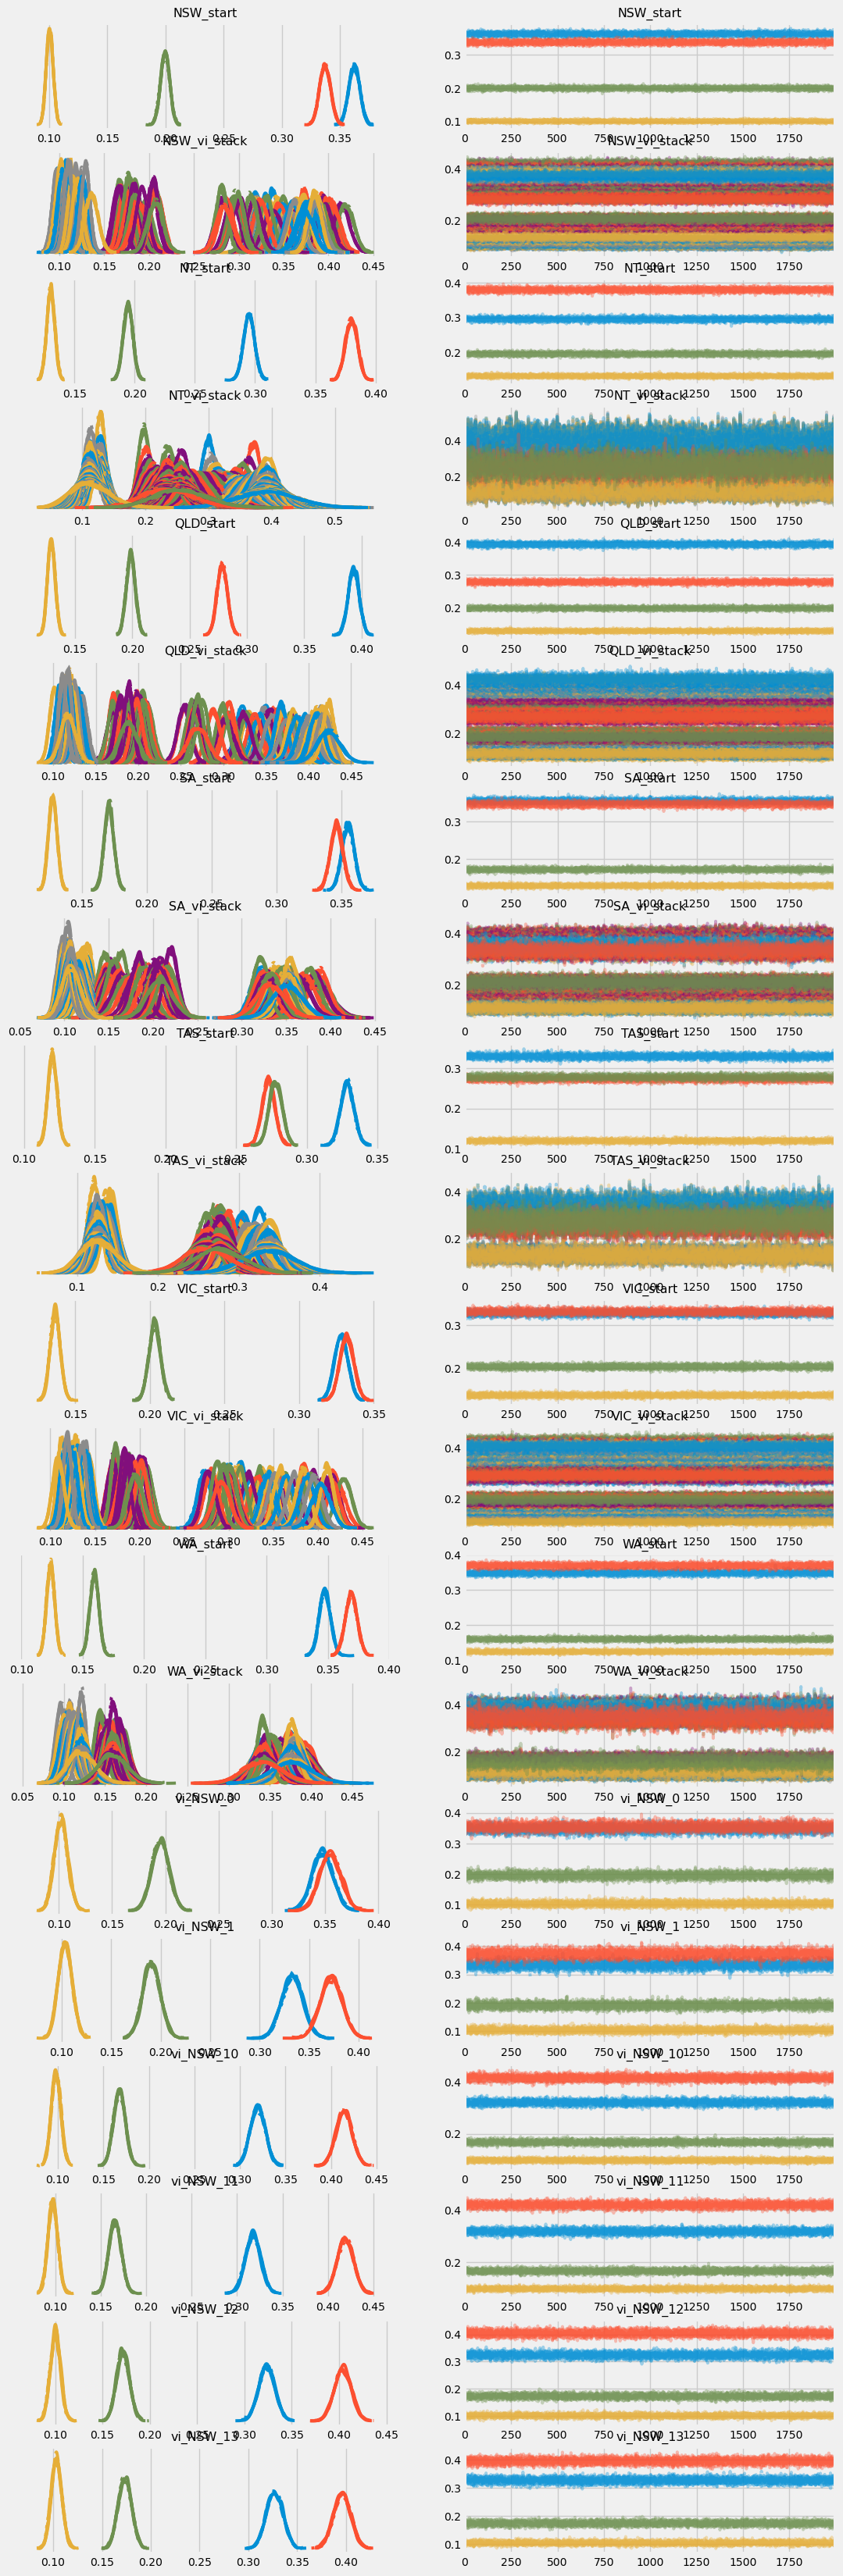

In [16]:
def fit_the_model(m: pm.Model) -> tuple[az.InferenceData, str]:
    """Run the model for each state and return the results."""

    ### Note: compiling the model and running it takes many minutes.       ###
    ###       Compile times are particularly long, and generates warnings. ###
    ###       This is a good time to take a 30 minute break.               ###
    ###       Typical compile time: 8 mins; typical tun time: 20 minutes.  ###
    
    sampling = sampler_settings()
    idata, glitches = bayes_tools.draw_samples(m, **sampling)
    results = idata, glitches

    return results


model_results = fit_the_model(the_model)

## Charts

### Extract the voting intention inference data for all states

In [17]:
def extract() -> tuple[dict[str, pd.DataFrame], str]:
    """Extract the voting untention results from the fitted model.
    Returns a dictionary of dataframes (one for each state) 
    and a text string for any problems/glitches in the inference process."""

    r = {}
    idata, glitches = model_results
    vi = {x.split("_", 1)[0]: x for x in idata.posterior if "_vi_" in x}
    for state, key in vi.items():
        r[state] = az.extract(idata, var_names=key).transpose("sample", ...).to_dataframe()[key]
        print(state, r[state].index.names)

    return r, glitches


extracted, problems = extract()

NSW ['chain', 'draw', 'months', 'parties']
NT ['chain', 'draw', 'months', 'parties']
QLD ['chain', 'draw', 'months', 'parties']
SA ['chain', 'draw', 'months', 'parties']
TAS ['chain', 'draw', 'months', 'parties']
VIC ['chain', 'draw', 'months', 'parties']
WA ['chain', 'draw', 'months', 'parties']


### Plot an individual state

In [18]:
def plot_state(state: str, df: pd.DataFrame, glitches: str) -> None:

    # set-up
    percents = [2.5, 25, 47.5]
    intensities = [
        (p - min(percents)) / (max(percents) - min(percents)) for p in percents
    ]
    min_intensity = 0.25
    intensity_fracs = [c * (1.0 - min_intensity) + min_intensity for c in intensities]
    start_month: pd.Period = pd.Period(FIRST_MONTH, freq="M")


    # plot
    vi_data = df.unstack(level="parties")
    _fig, ax = plt.subplots()
    medians = {}
    for p, party in enumerate(ORDERED_PARTIES):
        # get the party data
        specific_party_data = vi_data[vi_data.columns[p]]
        month_data = specific_party_data.unstack(level="months")
        median = month_data.median(axis=0)
        medians[party] = median

        # get the appropriate political party colors
        palette = {
            "Coalition": "Blues",
            "Labor": "Reds",
            "Greens": "Greens",
            "Others": "YlOrBr",
        }[party]
        color = plt.get_cmap(palette)

        for i, pct in enumerate(percents):
            quants = pct, 100 - pct
            label = f"{party} {quants[1] - quants[0]:0.0f}% HDI"

            x, y1, y2 = [], [], []
            for month in month_data.columns:
                period = start_month + int(month)
                vi = month_data[month]

                lower, upper = [vi[p].quantile(q=q / 100.0) for q in quants]
                x.append(str(period)[2:])
                y1.append(lower * 100)
                y2.append(upper * 100)

            intensity = intensity_fracs[i]
            ax.fill_between(
                x=x,  # type: ignore[arg-type]
                y1=y1,
                y2=y2,
                color=color(intensity),
                alpha=0.5,
                label=label,
                zorder=i + 1,
            )
        ax.text(
            x=x[-1],  # type: ignore[arg-type]
            y=y2[-1],
            s=f" {(y2[-1]+y1[-1])/2:.1f}",
            va="center",
            ha="left",
            color="gray",
            fontsize="xx-small",
        )
        ax.text(
            x=x[0],  # type: ignore[arg-type]
            y=y2[0] + 0.8,
            s=f" {party}",
            va="bottom",
            ha="left",
            color=color(intensity_fracs[-1]),
            fontsize="x-small",
        )

    ax.tick_params(axis="x", rotation=90, labelsize="x-small")
    poll_count = states_data[state]["n_polls"]
    plotting.finalise_plot(
        ax,
        title=f"Bayesian Aggregation: {state} Monthly Primary Voting Intention",
        ylabel="Per cent first preference votes",
        xlabel="Year-Month",
        legend={"loc": "center left", "fontsize": "xx-small", "ncol": 4},
        lfooter="House effects ignored. Dirichlet priors. "
        + f"Data sourced from Wikipedia. Based on {poll_count} state poll{'s' if poll_count > 1 else ''}.",
        rfooter="marktheballot.blogspot.com",
        rheader=glitches if glitches else None,
        tag="multi",
        show=True,
    )

### Plot all states

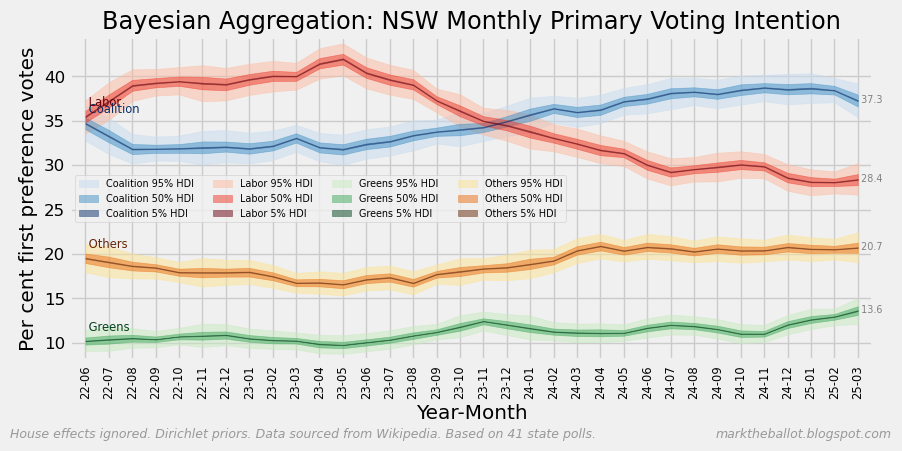

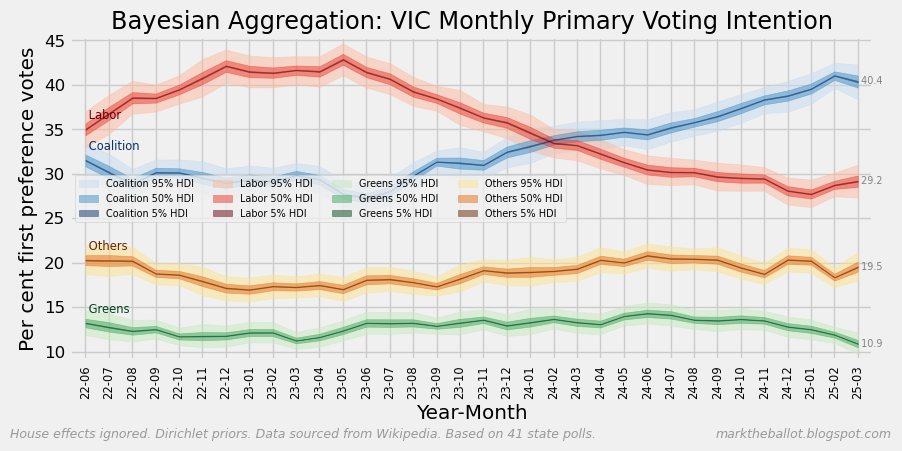

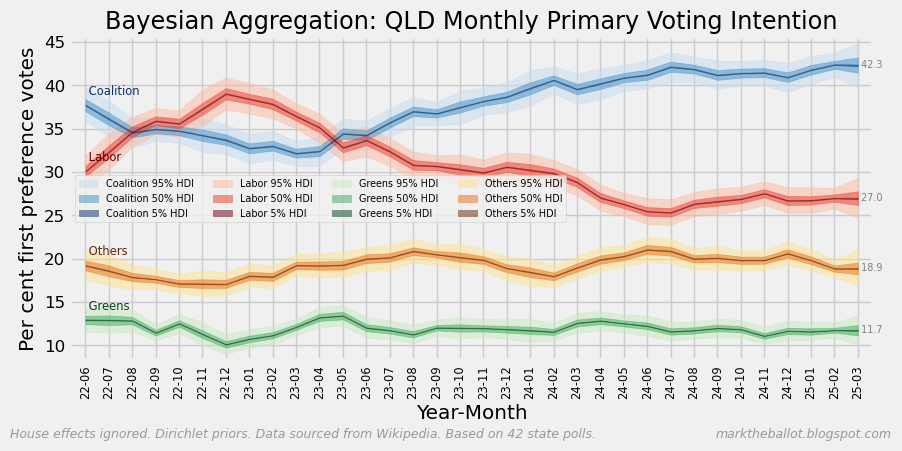

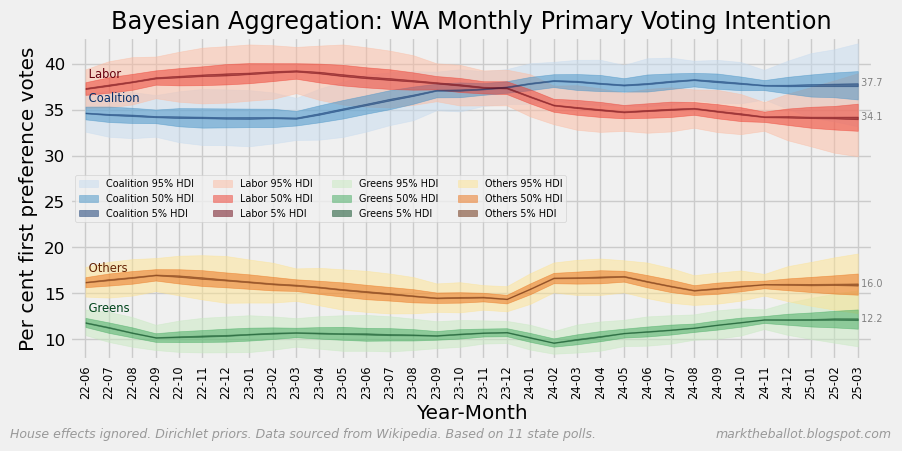

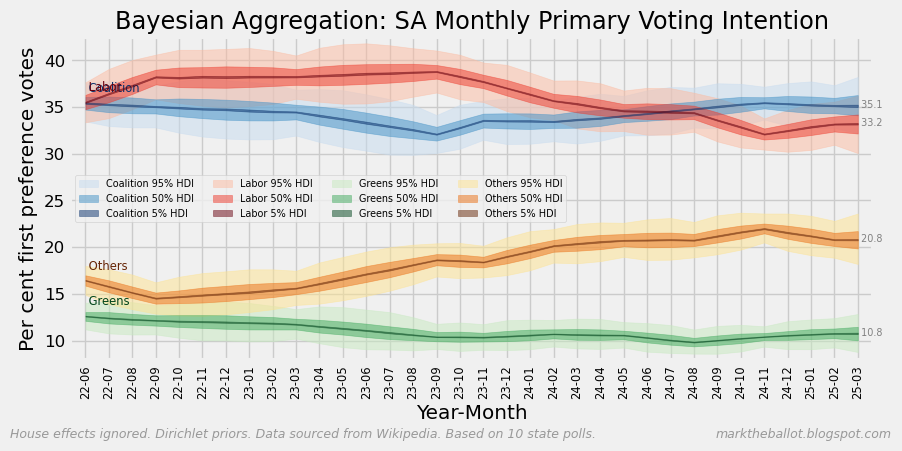

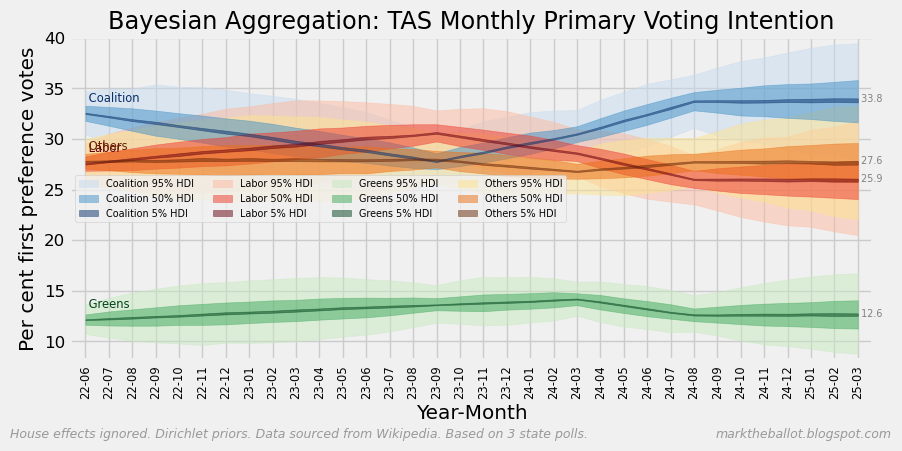

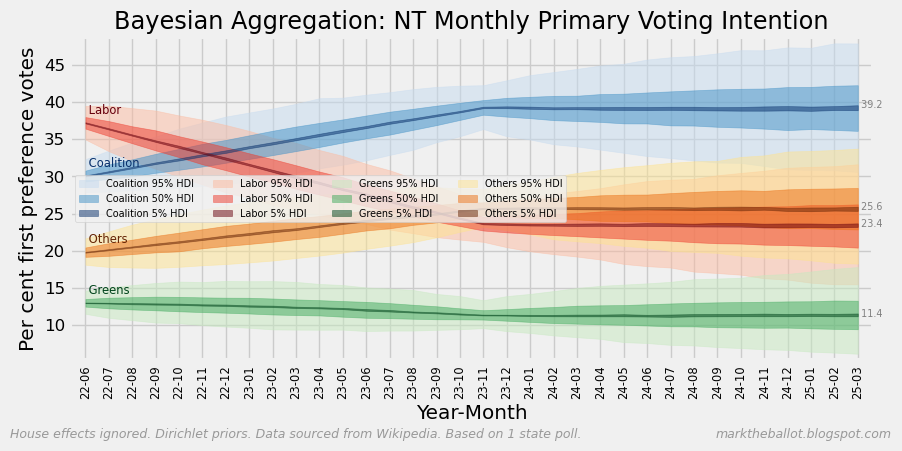

In [19]:
def plot_all_states(extracted: dict[str, pd.DataFrame]) -> None:
    """Plot the results for all states."""

    for state in ORDERED_STATES:
        if state not in extracted:
            continue
        plot_state(state, extracted[state], problems)


plot_all_states(extracted)

## Finished

In [20]:
print("Finished")

Finished
